
# Observations, IRFs and data reduction with H.E.S.S.


**Objective: Create datasets well-suited to the IRFs properties**

## Introduction

We  will use the `~gammapy.data.DataStore` to retrieve a
list of selected observations (`~gammapy.data.Observations`).


Then, we need to
define the ON region containing the source and the geometry of the
`~gammapy.datasets.SpectrumDataset` object we want to produce. We then
create the corresponding dataset Maker.

We have to define the Maker object that will extract the OFF counts from
reflected regions in the field-of-view. To ensure we use data in an
energy range where the quality of the IRFs is good enough we also create
a safe range Maker.

We can then proceed with data reduction with a loop over all selected
observations to produce datasets in the relevant geometry.

We can then explore the resulting datasets and look at the cumulative
signal and significance of our source. We finally proceed with model
fitting.

In practice, we have to:

- Create a `~gammapy.data.DataStore` pointing to the relevant data
- Apply an observation selection to produce a list of observations,
  a `~gammapy.data.Observations` object.
- Define a geometry of the spectrum we want to produce:

  - Create a `~regions.CircleSkyRegion` for the ON extraction region
  - Create a `~gammapy.maps.MapAxis` for the energy binnings: one for the
    reconstructed (i.e.measured) energy, the other for the true energy
    (i.e.the one used by IRFs and models)

- Create the necessary makers :

  - the spectrum dataset maker : `~gammapy.makers.SpectrumDatasetMaker` -
    the OFF background maker, here a `~gammapy.makers.ReflectedRegionsBackgroundMaker`
  - and the safe range maker : `~gammapy.makers.SafeMaskMaker`

- Perform the data reduction loop. And for every observation:

  - Apply the makers sequentially to produce a `~gammapy.datasets.SpectrumDatasetOnOff`
  - Append it to list of datasets


In [1]:
from pathlib import Path

# Check package versions
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import Regions, CircleSkyRegion

# %matplotlib inline
import matplotlib.pyplot as plt

## Setup

As usual, we’ll start with some setup …




In [2]:
from IPython.display import display
from gammapy.data import DataStore, get_irfs_features
from gammapy.datasets import (
    Datasets,
    MapDataset,
    create_map_dataset_from_observation
)
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    DatasetsMaker,
    MapDatasetMaker,
    FoVBackgroundMaker,
)
from gammapy.modeling import Fit
from gammapy.modeling.models import PiecewiseNormSpectralModel, TemplateSpatialModel, PowerLawNormSpectralModel, SkyModel, FoVBackgroundModel, GaussianPrior
from gammapy.maps import MapAxis, RegionGeom, WcsGeom, MapCoord, Map

from gammapy.catalog import CATALOG_REGISTRY


## Load Data

First, we select and load some H.E.S.S. observations of the Crab nebula
(simulated events for now).

We will access the events, effective area, energy dispersion, livetime
and PSF for containment correction.




In [3]:
datastore = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")

In [4]:
datastore.obs_table

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
20136,228.6125,-58.771667,320.56754,-0.8857012,38.512962,51.487038,195.73102,MSH15-52,228.6125,-59.271667,0.5,1682.0,1521.0269,0.9042966,101962602.0,101964284.0,2004-03-26,02:57:46.184,2004-03-26,03:25:48.184,4,"1,2,3,4",0,1.2132596,11243,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20137,228.6125,-59.771667,320.04724,-1.7397733,40.21616,49.78384,199.6482,MSH15-52,228.6125,-59.271667,0.5,902.0,819.2054,0.90821,101964441.0,101965343.0,2004-03-26,03:28:25.184,2004-03-26,03:43:27.184,4,"1,2,3,4",0,1.2139559,5693,MSH 15-52,msh1552,0.6156251,0.40738028,100.0
20151,228.6125,-58.771667,320.56754,-0.8857012,37.164658,52.835342,190.97171,custom,228.6125,-59.271667,0.5,1683.0,1530.479,0.9093755,102047232.0,102048915.0,2004-03-27,02:28:16.184,2004-03-27,02:56:19.184,4,"1,2,3,4",0,1.2214733,10722,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20275,187.27792,2.552389,289.7155,64.849686,36.18243,53.81757,49.144917,3C 273,187.27792,2.052389,0.5,1683.0,1525.8447,0.90662193,103665036.0,103666719.0,2004-04-14,19:51:40.184,2004-04-14,20:19:43.184,4,"1,2,3,4",0,1.121256,10646,Off data,offdata,--,0.33113113,100.0
20282,228.6125,-58.771667,320.56754,-0.8857012,37.13134,52.86866,169.21602,MSH 15-5-02,228.6125,-59.271667,0.5,1687.0,1543.3231,0.9148329,103678269.0,103679956.0,2004-04-14,23:32:13.184,2004-04-15,00:00:20.184,4,"1,2,3,4",0,1.1495326,11063,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20283,228.6125,-59.771667,320.04724,-1.7397733,36.221436,53.778564,175.77263,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1547.8253,0.9196823,103680087.0,103681770.0,2004-04-15,00:02:31.184,2004-04-15,00:30:34.184,4,"1,2,3,4",0,1.1512518,7628,MSH 15-52,msh1552,0.6156251,0.3801894,100.0
20301,228.6125,-58.771667,320.56754,-0.8857012,36.839905,53.160095,171.07347,MSH 15-5-02,228.6125,-59.271667,0.5,1683.0,1534.0626,0.9115048,103764878.0,103766561.0,2004-04-15,23:35:42.184,2004-04-16,00:03:45.184,4,"1,2,3,4",0,1.1503073,11624,MSH 15-52,msh1552,0.38821736,0.40738028,100.0
20302,228.6125,-59.771667,320.04724,-1.7397733,36.11632,53.88368,177.10521,MSH 15-5-02,228.6125,-59.271667,0.5,1682.0,1535.3478,0.9128108,103766698.0,103768380.0,2004-04-16,00:06:02.184,2004-04-16,00:34:04.184,4,"1,2,3,4",0,1.1493496,11794,MSH 15-52,msh1552,0.6156251,0.3801894,100.0


**Exercise:**
- Use the `datastore.obs_table` to display only observations `"RXJ 1713.7-3946"`object with quality zero, 4 telescopes, and a zenith angle lower than 65
- get list of their `OBS_ID` and use it to get a list of observations using `datastore.get_observations` method

In [5]:
from gammapy.utils.scripts import logic_parser

expression = '(OBJECT == "RXJ 1713.7-3946") and (N_TELS == 4) and (QUALITY == 0) and (ZEN_PNT < 65)'
obs_table = logic_parser(datastore.obs_table, expression)

obs_table

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
20326,259.29852,-39.762222,347.74036,-1.0417831,18.712194,71.2878,154.81943,RXJ 1713.7-3946,258.3879,-39.762222,0.6999909,1683.0,1500.009,0.891271,103858277.0,103859960.0,2004-04-17,01:32:21.184,2004-04-17,02:00:24.184,4,"1,2,3,4",0,1.1412385,16880,RX J1713.7-3946,rxj1713,0.7252947,0.23442288,100.0
20327,257.47733,-39.762222,346.91946,0.092252225,16.734882,73.265114,173.0282,RXJ 1713.7-3946,258.3879,-39.762222,0.69996744,1683.0,1497.074,0.889527,103860109.0,103861792.0,2004-04-17,02:02:53.184,2004-04-17,02:30:56.184,4,"1,2,3,4",0,1.1392112,16995,RX J1713.7-3946,rxj1713,0.6746846,0.20417379,100.0
20349,259.29852,-39.762222,347.74036,-1.0417831,16.722466,73.277534,186.67764,RXJ 1713.7-3946,258.3879,-39.762222,0.6999909,1682.0,1494.5023,0.888527,103947504.0,103949186.0,2004-04-18,02:19:28.184,2004-04-18,02:47:30.184,4,"1,2,3,4",0,1.1592567,16141,RX J1713.7-3946,rxj1713,0.7252947,0.20417379,100.0
20350,257.47733,-39.762222,346.91946,0.092252225,18.658506,71.34149,204.89865,RXJ 1713.7-3946,258.3879,-39.762222,0.69996744,1682.0,1497.6545,0.890401,103949330.0,103951012.0,2004-04-18,02:49:54.184,2004-04-18,03:17:56.184,4,"1,2,3,4",0,1.1565586,16081,RX J1713.7-3946,rxj1713,0.6746846,0.23442288,100.0
20396,258.3879,-39.06222,347.8998,-0.062237248,16.931627,73.068375,190.61954,RXJ 1713.7-3946,258.3879,-39.762222,0.70000076,1683.0,1499.001,0.89067197,104120195.0,104121878.0,2004-04-20,02:17:39.184,2004-04-20,02:45:42.184,4,"1,2,3,4",0,1.1642822,16418,RX J1713.7-3946,rxj1713,0.7092343,0.20417379,100.0
20397,258.3879,-40.462223,346.76566,-0.8830993,19.253716,70.746284,207.88188,RXJ 1713.7-3946,258.3879,-39.762222,0.70000076,1682.0,1505.1713,0.89487,104122008.0,104123690.0,2004-04-20,02:47:52.184,2004-04-20,03:15:54.184,4,"1,2,3,4",0,1.1711123,15798,RX J1713.7-3946,rxj1713,0.691681,0.23442288,100.0
20421,258.3879,-40.462223,346.76566,-0.8830993,16.978054,73.02195,191.29669,RXJ 1713.7-3946,258.3879,-39.762222,0.70000076,1683.0,1501.066,0.891899,104206423.0,104208106.0,2004-04-21,02:14:47.184,2004-04-21,02:42:50.184,4,"1,2,3,4",0,1.1678016,16313,RX J1713.7-3946,rxj1713,0.691681,0.20417379,100.0
20422,258.3879,-39.06222,347.8998,-0.062237248,19.3917,70.6083,208.46205,RXJ 1713.7-3946,258.3879,-39.762222,0.70000076,1683.0,1503.3414,0.893251,104208248.0,104209931.0,2004-04-21,02:45:12.184,2004-04-21,03:13:15.184,4,"1,2,3,4",0,1.1671224,16168,RX J1713.7-3946,rxj1713,0.7092343,0.23442288,100.0


In [6]:
obs_ids = obs_table["OBS_ID"]
observations = datastore.get_observations(obs_ids)

## How to choose the ON region size and the exclusion region sizes ?

Typically for point sources the ON region size is chosen to match the 68% containment radius of the PSF, while the exclusion region radius used to mask nearby sources is set to the 95% or 99% containment radius of the PSF. For extended sources one can consider the quadratic sum of the source radius and PSF radius.


In [7]:
obs0 = observations[0]
print(obs0.psf.info(
      fraction=[0.68, 0.95, 0.99, 0.68, 0.95, 0.99],
      energy_true=[1., 1., 1., 10, 10, 10]*u.TeV,
      offset=[0, 0, 0, 0, 0, 0]*u.deg)
     )


Summary PSF info
----------------
Theta          : size =     6, min =  0.000 deg, max =  2.500 deg
Energy hi      : size =    32, min =  0.013 TeV, max = 100.000 TeV
Energy lo      : size =    32, min =  0.010 TeV, max = 74.989 TeV
68.00 containment radius at offset = 0.0 deg and energy_true =  1.0 TeV: 0.100 deg
95.00 containment radius at offset = 0.0 deg and energy_true =  1.0 TeV: 0.302 deg
99.00 containment radius at offset = 0.0 deg and energy_true =  1.0 TeV: 0.500 deg
68.00 containment radius at offset = 0.0 deg and energy_true = 10.0 TeV: 0.059 deg
95.00 containment radius at offset = 0.0 deg and energy_true = 10.0 TeV: 0.188 deg
99.00 containment radius at offset = 0.0 deg and energy_true = 10.0 TeV: 0.306 deg



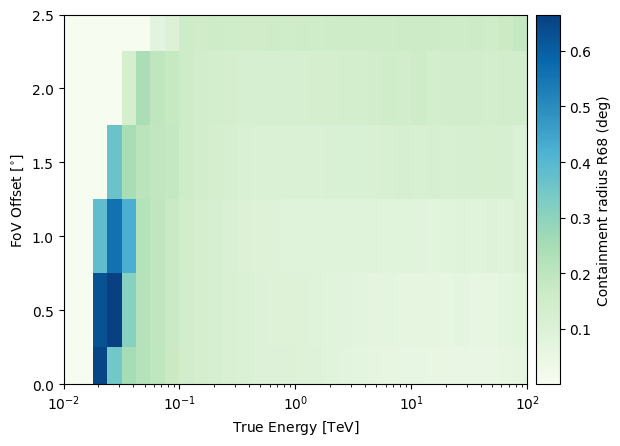

In [8]:
observations[0].psf.plot_containment_radius(fraction=0.68);


Here for simplicity we are are going to consider the median value in energy at offset zero for one observation. Ideally one should define for each observation an energy-dependent on-region at the offset matching the separation between the observation and target position.

In [9]:
on_region_radius = np.median(obs0.psf.containment_radius(fraction=0.68,
      energy_true=obs0.psf.axes["energy_true"].center,
      offset=0*u.deg))
print(on_region_radius)

0.0895707083866 deg


and we do the same for the exclusion radius

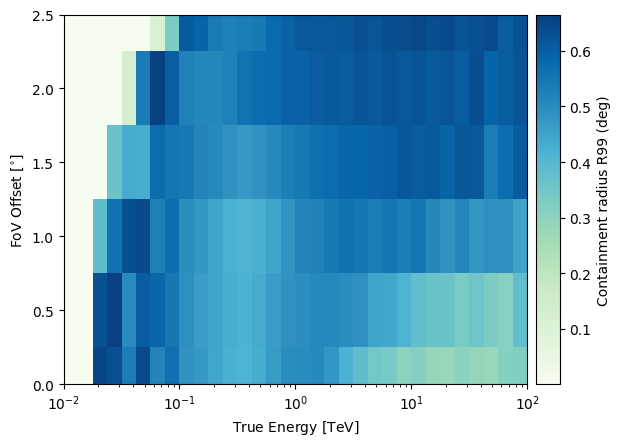

In [10]:
obs0.psf.plot_containment_radius(fraction=0.99);

In [11]:
exclusion_radius = np.median(obs0.psf.containment_radius(fraction=0.99,
      energy_true=obs0.psf.axes["energy_true"].center,
      offset=0*u.deg))
print(exclusion_radius)

0.4202093362808227 deg


## Define Target Region

The next step is to define a signal extraction region, also known as on
region. In the simplest case this is just a
[CircleSkyRegion](http://astropy-regions.readthedocs.io/en/latest/api/regions.CircleSkyRegion.html)_.




In [12]:
target_position = SkyCoord(347.3, -0.5, unit="deg", frame="galactic")
target_name = "RXJ 1713.7-3946"
#target_position = SkyCoord.from_name(target_name).galactic
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

## How to choose the dataset binning ?

A suitable binning for the dataset can be determined from the IRF,
For example the function  `gammapy.datasets.create_map_dataset_from_observation` use the following approach:
 * the number of bins per decade in energy is estimated from the energy resolution `eres`
      such as `diff(ereco.edges)/ereco.center ~ min(eres)`
 * the bin size estimated from the minimal 68% containment radius of the psf
 * the width estimated from the rad_max or the offset_max or the PSF
 * the min/max true energy is determined from the PSF axis
 * the min/max reco energy is determined from the background axis


In [13]:
%%capture
from gammapy.datasets import create_map_dataset_from_observation
empty_datasets = [create_map_dataset_from_observation(obs) for obs in observations]

In [14]:
for d in empty_datasets[1:3]:
    print(d.counts.geom.wcs)
    print(d.counts.geom.axes[0])
    print(d.exposure.geom.axes[0])

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---CAR' 'DEC--CAR' 
CRVAL : 257.47731666009 -39.762222222222 
CRPIX : 48.5 48.5 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.05729566887021065 0.05729566887021065 
NAXIS : 96  96
MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 27        
	node type  : edges     
	edges min  : 1.0e-01 TeV
	edges max  : 1.0e+02 TeV
	interp     : log       

MapAxis

	name       : energy_true
	unit       : 'TeV'     
	nbins      : 37        
	node type  : edges     
	edges min  : 1.0e-02 TeV
	edges max  : 1.0e+02 TeV
	interp     : log       

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---CAR' 'DEC--CAR' 
CRVAL : 259.29851667325 -39.762222222222 
CRPIX : 48.5 48.5 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.05729566887021065 0.05729566887021065 
NAXIS : 96  96
MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 27        
	node type  : edges     
	edges min  : 1.0e-01 TeV
	edges m

Note that here the binning is be different for each dataset so we can't stack them if needed. Let's create a common geometry that emcompass these and have a similar bining :

In [15]:
from gammapy.datasets.utils import create_global_dataset
reference_dataset = create_global_dataset(empty_datasets,
                                          position=target_position,
                                          binsz=0.02*u.deg,
                                          energy_min=0.5*u.TeV,
                                          energy_max=50*u.TeV,
                                          width=8*u.deg,
                                          name="HESS_"+target_name
                                         )

In [16]:
print(reference_dataset.counts.geom.wcs)
print(reference_dataset.counts.geom.axes[0])
print(reference_dataset.exposure.geom.axes[0])

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-CAR' 'GLAT-CAR' 
CRVAL : 347.3 -0.5 
CRPIX : 200.5 200.5 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.02 0.02 
NAXIS : 400  400
MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 20        
	node type  : edges     
	edges min  : 5.0e-01 TeV
	edges max  : 5.0e+01 TeV
	interp     : log       

MapAxis

	name       : energy_true
	unit       : 'TeV'     
	nbins      : 41        
	node type  : edges     
	edges min  : 1.0e-02 TeV
	edges max  : 1.0e+02 TeV
	interp     : log       



## Create exclusion mask

In order to scale the background model we have to mask the region with significant emission as explained in https://docs.gammapy.org/2.0/tutorials/details/mask_maps.html#creating-an-exclusion-mask

We start with know sources :
First we load the H.E.S.S. Galactic plane survey (HGPS) source catalog


In [17]:
hgps = CATALOG_REGISTRY.get_cls("hgps")()

print(hgps)

SourceCatalogHGPS:
    name: hgps
    description: H.E.S.S. Galactic plane survey (HGPS) source catalog
    sources: 78



and select the sources inside our analysis region

In [18]:
hgps_models = hgps.to_models()

geom = reference_dataset.counts.geom
geom_image = geom.to_image()
inside_geom = geom_image.contains(hgps_models.positions)
source_models = hgps_models[inside_geom]
print(source_models.names)

/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/astropy/units/quantity.py:653: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/qremy/Work/GitHub/gammapy/gammapy/modeling/models/spatial.py:660: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=COPY_IF_NEEDED)


['HESS J1702-420', 'HESS J1708-410', 'HESS J1713-381', 'HESS J1713-397', 'HGPSC 045', 'HESS J1718-374', 'HESS J1718-385']


In [19]:
source_regions = []
for source in source_models:
    radius = exclusion_radius + source.evaluation_radius
    source_regions.append(CircleSkyRegion(source.position, radius)) 


We add a $\pm 0.5\degree$ band to mask the contribution from diffuse emission in the Galactic plane

In [20]:
regions_ds9 = "galactic;box(0,0,180,1, 0)"
regions = list(Regions.parse(regions_ds9, format="ds9"))
print(regions)

[<RectangleSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
    (0., 0.)>, width=180.0 deg, height=1.0 deg, angle=0.0 deg)>]


/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


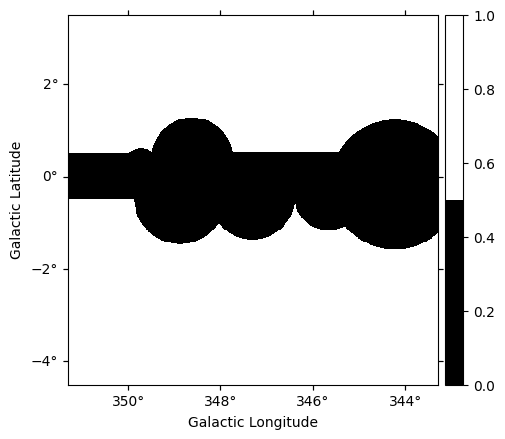

In [21]:
# to define the exclusion mask we take the inverse
exclusion_source_mask3d = ~geom.region_mask(source_regions)
exclusion_source_mask = ~geom.region_mask(source_regions)

exclusion_mask3d = ~geom.region_mask(regions+source_regions)
exclusion_mask = ~geom_image.region_mask(regions+source_regions)
exclusion_mask.plot(add_cbar=True)
plt.show()

## Data reduction 3D
The workflow but we have to use different makers:



In [22]:
dataset_maker = MapDatasetMaker()
safe_mask_maker = SafeMaskMaker(methods=["aeff-max", "offset-max"], aeff_percent=10, offset_max=2*u.deg)
bkg_maker = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)
makers = [dataset_maker, safe_mask_maker, bkg_maker] # the order is important


Here instread of a loop we perform the data reduction chain using the `DatasetsMaker`

In [23]:
makers = [dataset_maker, safe_mask_maker, bkg_maker] # the order is important

datasets_maker = DatasetsMaker(makers=makers,
                         stack_datasets=True, #this time we stack to save memory usage
                         n_jobs=4) #dataset computation can run in parallel

datasets = datasets_maker.run(
                            dataset=reference_dataset,
                            observations=observations,
                        )
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : HESS_RXJ 1713.7-3946
  Instrument : 
  Models     : 




/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outpu

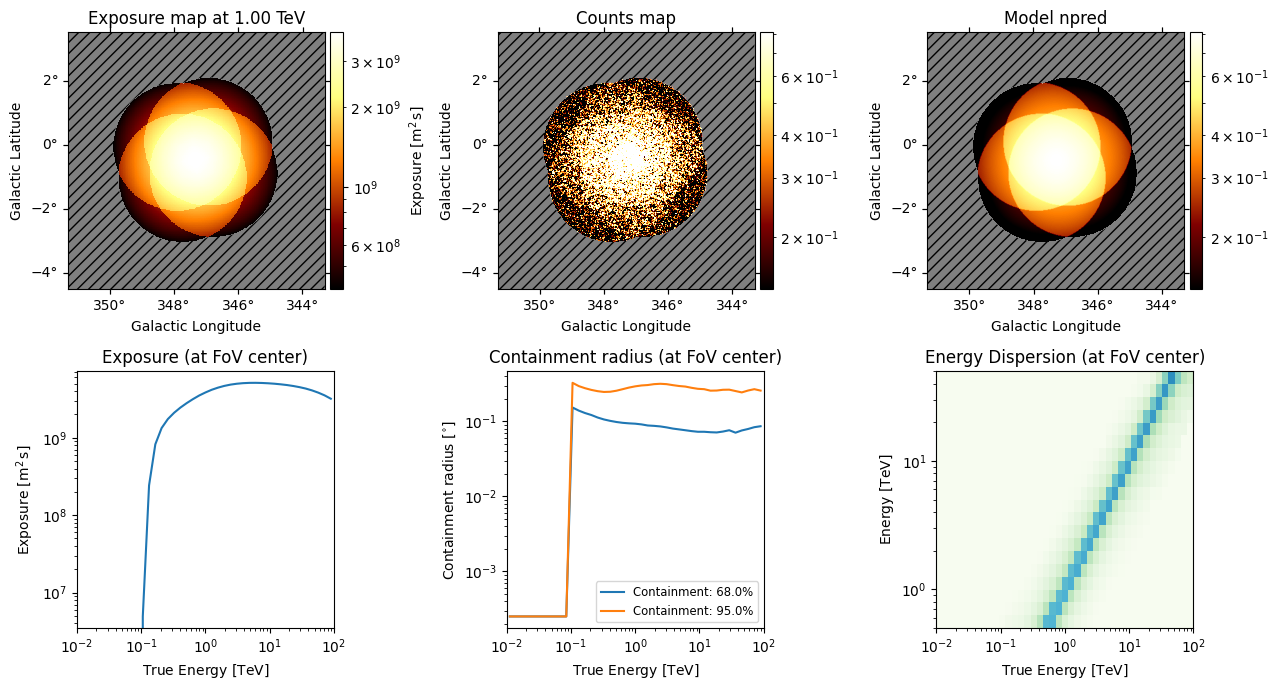

In [24]:
datasets[0].peek()
plt.show()

By default only the normalisation of background model of each observation is reffited. In order to correct for the spectral shape of the background model one can refit a normalisation in each energy bin. This is particularly important below the background peak where the curvature of the model is not always good.


/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


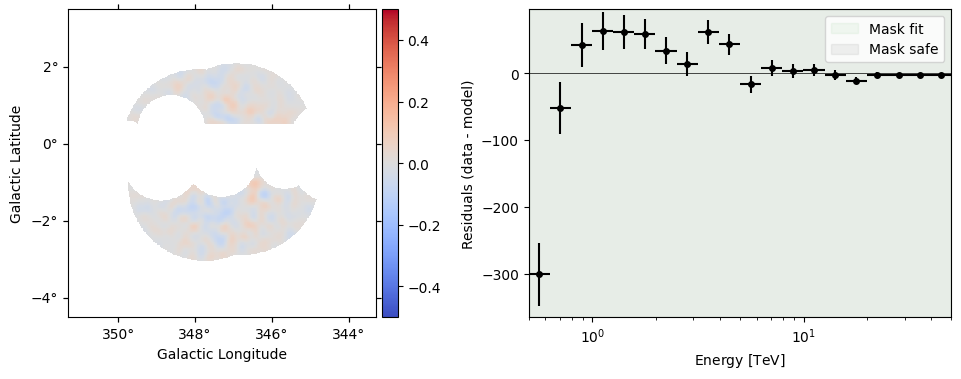

In [25]:
datasets[0].mask_fit = exclusion_mask3d
datasets[0].plot_residuals(kwargs_spatial=dict(vmin=-0.5, vmax=0.5))

datasets[0].mask_fit = None

The fit cannot be performed in each energy bin because there is not enough statistic at high energy 

In [26]:
datasets[0].counts.plot_interactive()
plt.show()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

here we compute the sparcity that gives the fraction of empty bins

In [27]:
def sparsity(image):
    return 1.0 - (np.count_nonzero(image) / float(image.size))

counts_sparsity = np.array([
    sparsity(counts.data[exclusion_mask.data&(bkg.data>0)]) for counts, bkg in zip(
        datasets[0].counts.iter_by_image(), datasets[0].background.iter_by_image()
    )])

Text(0, 0.5, 'Sparcity')

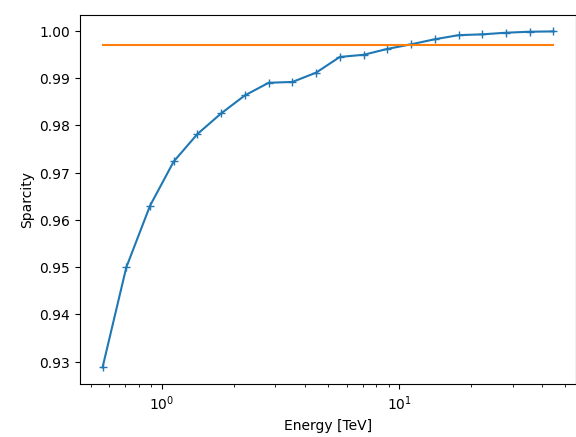

In [28]:
energy_center = datasets[0].counts.geom.axes[0].center
energy_edges = datasets[0].counts.geom.axes[0].edges

thr = 0.997
plt.semilogx(energy_center, counts_sparsity, "+-")
plt.semilogx(energy_center, [thr]*len(energy_center))
plt.xlabel("Energy [TeV]")
plt.ylabel("Sparcity")

so we choose only bins below a give threshold in sparcity 

In [29]:
#energy_bins = energy[counts_sparsity<1]
energy_bins = np.append(energy_edges[:-1][counts_sparsity<thr], energy_edges[-1])

In [30]:
energy_bins

<Quantity [ 0.5       ,  0.62946271,  0.7924466 ,  0.99763116,  1.25594322,
            1.58113883,  1.99053585,  2.50593617,  3.15478672,  3.97164117,
            5.        ,  6.29462706,  7.92446596, 50.        ] TeV>

In [31]:
spectral_model = PiecewiseNormSpectralModel(energy_bins)

In [32]:
bkg_maker = FoVBackgroundMaker(method="fit", spectral_model=spectral_model, exclusion_mask=exclusion_mask)
offset_mask_maker = SafeMaskMaker(methods=["offset-max"], offset_max=2*u.deg)
aeff_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)
# here we apply the aeff_mask_maker only after the bkg_maker to avaoid trying to fit an energy range that have been masked
# if the exlusion region is large we could also apply the offset_mask_maker after
# so we a larger region and then more stat in each energy bin to fit the background per energy bin 

makers = [dataset_maker, offset_mask_maker, bkg_maker, aeff_mask_maker] # the order is important
datasets_maker = DatasetsMaker(makers=makers,
                         stack_datasets=False, #we don't stack to inspect the fitted bkg for each dataset
                         n_jobs=4)#the fit has more parameter now so take more time then we run it in parallel

datasets = datasets_maker.run(
                            dataset=reference_dataset,
                            datasets=np.repeat(reference_dataset, len(observations)),
                            observations=observations,
                        )

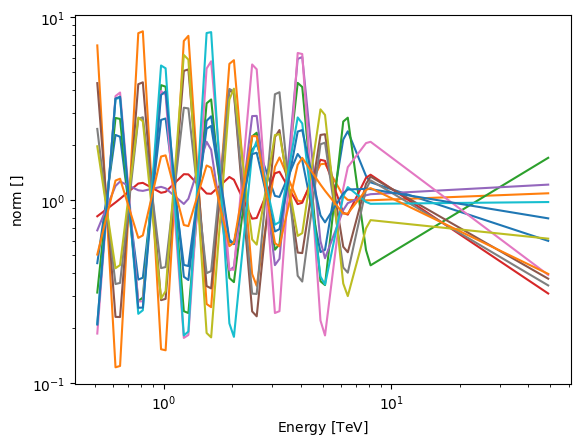

In [33]:
for d in datasets:
    d.background_model.spectral_model.plot([0.5,50]*u.TeV)

In [34]:
stacked = datasets.stack_reduce(name="hess_rxj_stacked")


In [35]:
stacked.counts.geom

Now let's look at the stacked dataset

We can see that the spectral residuals have clearly improved

/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


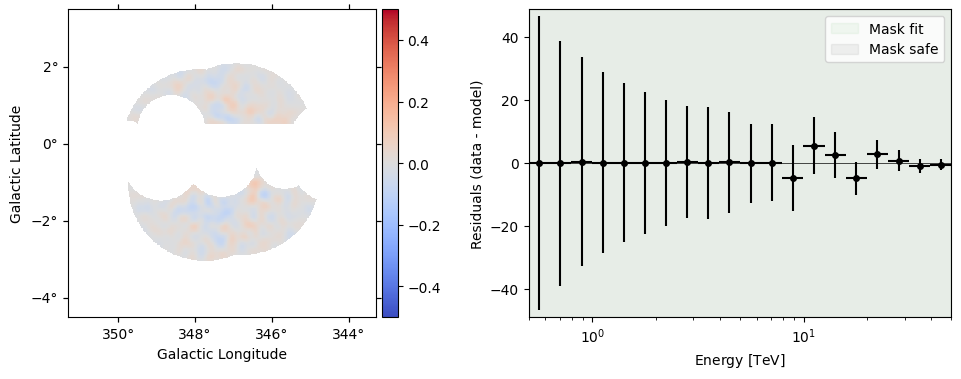

In [36]:
stacked.mask_fit = exclusion_mask3d
stacked.plot_residuals(kwargs_spatial=dict(vmin=-0.5, vmax=0.5))

stacked.mask_fit = None

# Prepare the models for diffuse emission
Now we load an intersellar emission model (IEM) created with https://github.com/cosmicrays/hermes for the CTA-GPS simulation https://zenodo.org/records/10008527. We added lighter versions in the repo so you can direclty read one of theses using TemplateSpatialModel.read method:

In [37]:
template_iem = TemplateSpatialModel.read("./models/IEM_varmin_rescaled_rxj.fits.gz", normalize=False) 


These template are 3D maps so the normalize=False option is important to keep spectral information unchanged. We add that into a SkyModel together with a PowerLawNormSpectralModel that allows to refit the normalisation of the template.

In [38]:
model_iem = SkyModel(spatial_model=template_iem,
                            spectral_model=PowerLawNormSpectralModel(),
                            name="IEM_varmin_rescaled"
                           )

stacked.models = model_iem


In [39]:
template_iem.plot_interactive(add_cbar=True)
plt.show()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

There is diffuse emission everywhere, even outside the exclusion mask, so does it bias the background fit ?

In [40]:
data = (model_iem.evaluate_geom(geom.as_energy_true)*exclusion_mask3d)
    
Map.from_geom(geom, data=data).plot_interactive(add_cbar=True)

plt.show()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

Looking at the residual yes :

<Figure size 640x480 with 0 Axes>

/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


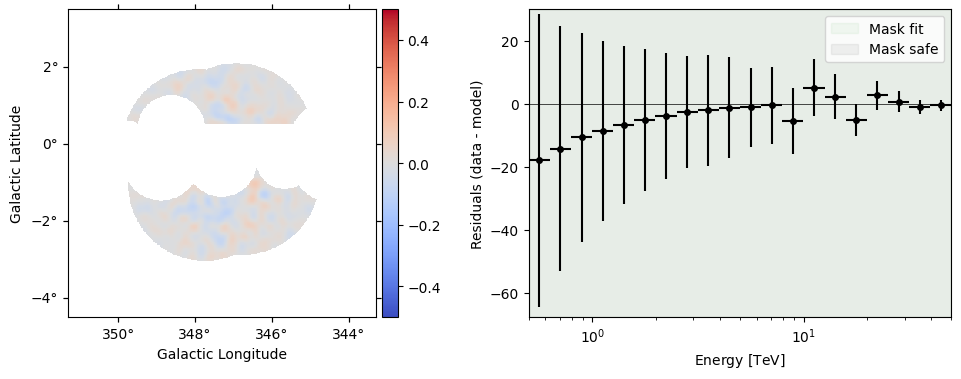

In [41]:
stacked.mask_fit = exclusion_mask3d


plt.figure()
plt.show()# display bug have to call this before but why ???

stacked.plot_residuals(kwargs_spatial=dict(vmin=-0.5, vmax=0.5)) 
plt.show()


So we can fit the diffuse together with the background. Usually we would do that on a larger region as it would be better constrained but here let's just add a Prior on the diffuse that will limit it's range of possible values and the correlation with the background.

In [42]:
bkg_stacked =  FoVBackgroundModel(dataset_name=stacked.name,
                                  spectral_model=PiecewiseNormSpectralModel(energy_bins)
                                 )
model_iem.spectral_model.norm.prior = GaussianPrior(mu=1, sigma=1)

stacked.models = [model_iem, bkg_stacked]

In [43]:
%%time 

fit = Fit()

result = fit.run(datasets=stacked)

print(result)


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 371
	total stat : 75011.29

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: user 9.26 s, sys: 256 ms, total: 9.51 s
Wall time: 9.46 s


In [44]:
stacked.models.parameters.free_parameters.to_table()

type,name,value,unit,error,min,max,frozen,link,prior
str1,str7,float64,str1,float64,float64,float64,bool,str1,str13
,norm,1.5762e+00,,8.542e-01,nan,nan,False,,GaussianPrior
,norm_0,9.8793e-01,,2.443e-01,nan,nan,False,,
,norm_1,9.8611e-01,,2.408e-01,nan,nan,False,,
,norm_2,9.8420e-01,,2.371e-01,nan,nan,False,,
,norm_3,9.8428e-01,,2.339e-01,nan,nan,False,,
,norm_4,9.8207e-01,,2.304e-01,nan,nan,False,,
,norm_5,9.8238e-01,,2.277e-01,nan,nan,False,,
,norm_6,9.8479e-01,,2.253e-01,nan,nan,False,,
,norm_7,9.8486e-01,,2.220e-01,nan,nan,False,,


Now the spectral residuals are flat again by construction but this time we included the prior knowledge that diffuse emission exits.

/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


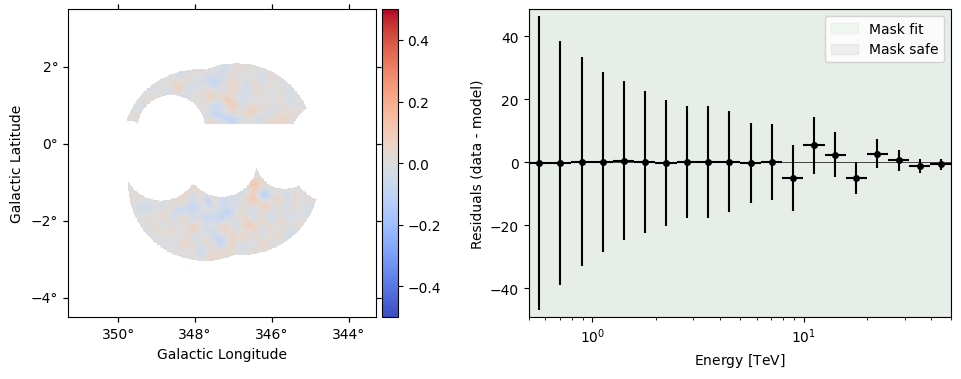

In [45]:
stacked.plot_residuals(kwargs_spatial=dict(vmin=-0.5, vmax=0.5))

stacked.mask_fit = None

Now let's re-run the background fit run-by-run keeping the diffuse frozen.

In [46]:
model_iem.freeze()
reference_dataset.models = model_iem
datasets.models  = model_iem
for d in datasets:
    d.mask_safe = None # remove as we need to fit the bkg before applying the energy threshold from the aeff_mask_maker

makers = [offset_mask_maker, bkg_maker, aeff_mask_maker] # removed the MapDatasetMaker as we have them already
datasets_maker = DatasetsMaker(makers=makers,
                         stack_datasets=False, #we don't stack to inspect the fitted bkg for each dataset
                         n_jobs=4)#the fit has more parameter now so take more time then we run it in parallel


datasets = datasets_maker.run(
                            dataset=reference_dataset,
                            datasets=datasets,
                            observations=observations,
                        )

In [47]:
stacked = datasets.stack_reduce(name="hess_rxj_stacked")

bkg_stacked =  FoVBackgroundModel(dataset_name=stacked.name,
                                  spectral_model=PiecewiseNormSpectralModel(energy_bins)
                                 )
model_iem.spectral_model.norm.prior = GaussianPrior(mu=1, sigma=1)

stacked.models = [model_iem, bkg_stacked]


/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


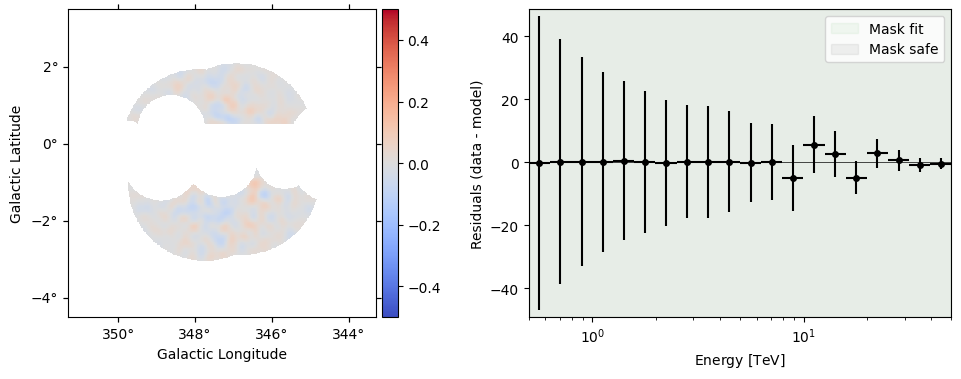

In [48]:
stacked.mask_fit = exclusion_mask3d
stacked.plot_residuals(kwargs_spatial=dict(vmin=-0.5, vmax=0.5))
plt.show()

stacked.mask_fit = None

In [49]:
Datasets(stacked).write(
    filename="./datasets/hess_rxj_datasets.yaml",
    filename_models="./models/hess_rxj_models.yaml",
    overwrite=True,
)
#TODO: add a save_compressed option on Datasets.write and Models.write

Template file already exits, and overwrite is False


**Now you can check the joint analysis tutorials to read this dataset and analyse together H.E.S.S. and Fermi-LAT data**